In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from re import sub
from decimal import Decimal
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime
import time
import matplotlib.pylab as plt
import math

In [2]:
TRAIN = time.mktime(datetime.strptime("20-01-02", '%y-%m-%d').timetuple())


In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def mdy_to_ymd(d):
    return time.mktime(datetime.strptime(d, '%d-%b-%y').timetuple())

In [4]:
dataset = pd.read_csv("dataset.csv")
dataset.columns = ["date","price","open","high","low","vol","change"]

In [5]:
for col in ["price","open","high","low","vol","change"]:
    dataset[col] = dataset.apply(lambda row : (lambda x: 0 if x == '-' else float(x))(sub(r'[^\d.-]', '', row[col])), axis = 1)

dataset["date"] = dataset.apply(lambda row : mdy_to_ymd(row['date']), axis = 1)

In [6]:
dataset["PrevPrice"] = dataset.price[1:].append(pd.Series([0],index=[dataset.shape[0]])).reset_index(drop=True)

In [70]:
train = dataset[dataset.date < TRAIN]
test = dataset[dataset.date >= TRAIN]

In [8]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train[["PrevPrice"]],train.price)



LinearRegression()

In [9]:
df = pd.DataFrame()
df["target"] = test.price
df["predict"] = pd.Series(model.predict(test[["PrevPrice"]]))

In [10]:
df["isAcc"] = (df.target*0.95 <= df.predict) & (df.predict <= df.target*1.05)
df["isAcc"] = df.apply(lambda row: 1 if row["isAcc"] else 0,axis = 1)
df.isAcc.sum()/df.shape[0]*100

85.59670781893004

<AxesSubplot:xlabel='predict'>

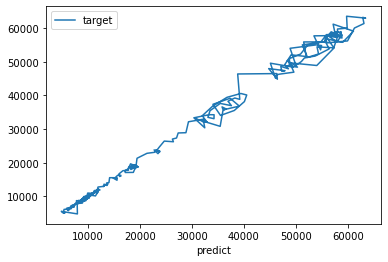

In [11]:
df.plot(x = "predict", y = "target")

In [12]:
np.abs(df.target - df.predict).mean()

582.8963196947335

In [13]:
mean_squared_error(df.target,df.predict,squared=False)

1086.5880430569164

In [31]:
SIZE = 60 #we take 2 past months here for each time-series point
COLUMNS = ['t{}'.format(x) for x in range(SIZE)] + ['target']
df = []
for i in range(SIZE, dataset.shape[0]):
    df.append(dataset.loc[i-SIZE:i, 'price'].tolist())
df = pd.DataFrame(df, columns=COLUMNS)
df

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t51,t52,t53,t54,t55,t56,t57,t58,t59,target
0,57807.1,57720.3,53560.8,54841.4,55036.5,54020.5,48963.6,50088.9,51143.6,51729.5,...,57799.5,55851.9,54879.0,52311.0,50982.3,48855.6,48792.5,48428.0,50395.1,48424.2
1,57720.3,53560.8,54841.4,55036.5,54020.5,48963.6,50088.9,51143.6,51729.5,53820.2,...,55851.9,54879.0,52311.0,50982.3,48855.6,48792.5,48428.0,50395.1,48424.2,49595.5
2,53560.8,54841.4,55036.5,54020.5,48963.6,50088.9,51143.6,51729.5,53820.2,56483.2,...,54879.0,52311.0,50982.3,48855.6,48792.5,48428.0,50395.1,48424.2,49595.5,45164.0
3,54841.4,55036.5,54020.5,48963.6,50088.9,51143.6,51729.5,53820.2,56483.2,55646.1,...,52311.0,50982.3,48855.6,48792.5,48428.0,50395.1,48424.2,49595.5,45164.0,46136.7
4,55036.5,54020.5,48963.6,50088.9,51143.6,51729.5,53820.2,56483.2,55646.1,56207.1,...,50982.3,48855.6,48792.5,48428.0,50395.1,48424.2,49595.5,45164.0,46136.7,46345.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3876,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3877,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3878,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3879,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [15]:
df["date"] = dataset.head(dataset.shape[0] - 60).date

In [16]:
train = df[df.date < TRAIN]
test = df[df.date >= TRAIN]

In [17]:
train = train.drop(columns=["date"])
test = test.drop(columns=["date"])


In [18]:
from sklearn.linear_model import Lasso
model = Lasso()
model.fit(train.drop(columns=["target"]),train.target)

E:\AnacondaPy\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65133764.53373925, tolerance: 3914614.2338123904
  model = cd_fast.enet_coordinate_descent(


Lasso()

<AxesSubplot:>

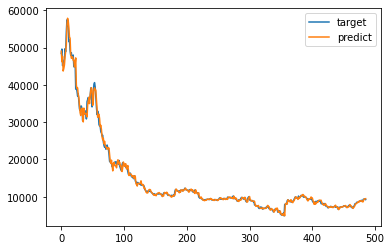

In [19]:
df = pd.DataFrame()
df["target"] = test.target
df["predict"] = pd.Series(model.predict(test.drop(columns=["target"])))
df.plot()

478.229769957594


<AxesSubplot:xlabel='predict'>

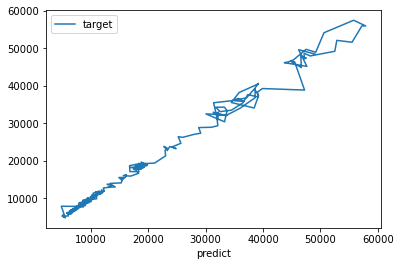

In [20]:
print(np.abs(df.target - df.predict).mean())
df.plot(x = "predict", y ="target")

In [21]:
mean_squared_error(df.target,df.predict,squared=False)

871.6882047325115

In [22]:
df["isAcc"] = (df.target*0.95 <= df.predict) & (df.predict <= df.target*1.05)
df["isAcc"] = df.apply(lambda row: 1 if row["isAcc"] else 0,axis = 1)
df.isAcc.sum()/df.shape[0]*100

81.6872427983539

In [26]:
mean_squared_error(df.target,df.predict,squared=False)

8713.3447180173

## 